## Assignment 02 CS626 : POS tagging using CRF 

This assignment involved Parts Of Speech (POS) tagging using Conditional Random Fields (CRF) approach to achieve better accuracy than traditional HMM POS tagging techniques. 

We used the following steps:

1. Data Preparation.
2. Defining Feature Functions.
3. Training a CRF classifier with Grid Search cross validation to find CRF model with best hyperparameters.
4. Checking accuracy of best CRF model on validation and test sets.
5. Error Analysis : Plotting a confusion matrix to get information about maximal confusions. 

### Step_01 : Data Preparation

In [3]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import sklearn
from tqdm import tqdm
import pickle

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

In [51]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to C:\Users\DIVYANSHU.LAPTOP-
[nltk_data]     LRGNN2BQ\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\DIVYANSHU.LAPTOP-
[nltk_data]     LRGNN2BQ\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
# reading the Brown tagged sentences
brown = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

In [5]:
# printing the first few tagged sentences
print(brown[:2])
print(len(brown))

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [6]:
nltk_data = brown

In [7]:
# spliting data into training and validation and test set

## Train test split : 85 - 15 
train_set,test_set = train_test_split(nltk_data,train_size=0.85,test_size=0.15,random_state=101)

## Train val split : 80 - 20
train_set,val_set = train_test_split(nltk_data,train_size=0.80,test_size=0.20,random_state=101)

### Defining Features for feature function:

The following features are defined:
* word: the word itself.
* pos: POS tag of the word.
* prevword: previous word.
* prevpos: POS tag of previous word.
* prev2word: second previous word to the given word.
* prev2pos: POS tag of second previous word.
* nextword: next word.
* nextpos: POS tag of next word.
* pref_1, pref_2, pref_3, pref_4: 1,2,3 and 4 lenght prefix of the word.
* suff_1, suff_2, suff_3, suff_4: 1,2,3 and 4 lenght suffix of the word.

In [43]:
# extract features from a given sentence
def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]
    
    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]
        
    # first word
    if i==0 or i==1:
        prev2word = '<START>'
        prev2pos = '<START>'
    else:
        prev2word = sent[i-2][0]
        prev2pos = sent[i-2][1]
    
    # last word
    if i >= len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]
    
    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]
    
    # rule_state = rule_based_tagger.tag([word])[0][1]
    
    return {'word':word,            
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,          
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4,
            'prev2word': prev2word,
            'prev2pos': prev2pos           
           }  

In [9]:
# Checking if our word feature is working correctly:
print(train_set[0][0:5])

word_features(train_set[0],3)

[('A', 'DET'), ('Newfoundland', 'NOUN'), ('sat', 'VERB'), ('solemnly', 'ADV'), ('beside', 'ADP')]


{'word': 'solemnly',
 'prevword': 'sat',
 'prevpos': 'VERB',
 'nextword': 'beside',
 'nextpos': 'ADP',
 'suff_1': 'y',
 'suff_2': 'ly',
 'suff_3': 'nly',
 'suff_4': 'mnly',
 'pref_1': 's',
 'pref_2': 'so',
 'pref_3': 'sol',
 'pref_4': 'sole',
 'prev2word': 'Newfoundland',
 'prev2pos': 'NOUN'}

In [10]:
# defining a few more functions to extract featrues, postags and words from sentences

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for word, postag in sent]

def sent2tokens(sent):
    return [word for word, postag in sent]    

In [11]:
 # create training, validation and test sets
X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

X_valid = [sent2features(s) for s in val_set]
y_valid = [sent2labels(s) for s in val_set]

X_test = [sent2features(s) for s in test_set]
y_test = [sent2labels(s) for s in test_set]

#### Checking the training set produced

In [12]:
print(X_train[0][0:10])
print(y_train[0][0:10])

[{'word': 'A', 'prevword': '<START>', 'prevpos': '<START>', 'nextword': 'Newfoundland', 'nextpos': 'NOUN', 'suff_1': 'A', 'suff_2': 'A', 'suff_3': 'A', 'suff_4': 'A', 'pref_1': 'A', 'pref_2': 'A', 'pref_3': 'A', 'pref_4': 'A', 'prev2word': '<START>', 'prev2pos': '<START>'}, {'word': 'Newfoundland', 'prevword': 'A', 'prevpos': 'DET', 'nextword': 'sat', 'nextpos': 'VERB', 'suff_1': 'd', 'suff_2': 'nd', 'suff_3': 'and', 'suff_4': 'land', 'pref_1': 'N', 'pref_2': 'Ne', 'pref_3': 'New', 'pref_4': 'Newf', 'prev2word': '<START>', 'prev2pos': '<START>'}, {'word': 'sat', 'prevword': 'Newfoundland', 'prevpos': 'NOUN', 'nextword': 'solemnly', 'nextpos': 'ADV', 'suff_1': 't', 'suff_2': 'at', 'suff_3': 'sat', 'suff_4': 'sat', 'pref_1': 's', 'pref_2': 'sa', 'pref_3': 'sat', 'pref_4': 'sat', 'prev2word': 'A', 'prev2pos': 'DET'}, {'word': 'solemnly', 'prevword': 'sat', 'prevpos': 'VERB', 'nextword': 'beside', 'nextpos': 'ADP', 'suff_1': 'y', 'suff_2': 'ly', 'suff_3': 'nly', 'suff_4': 'mnly', 'pref_1':

### 1. Building CRF model

In [53]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True   
)

# for _ in tqdm(range(100), desc="Training CRF Model"):
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [ ]:
# # saving the model to a pickle file

with open('trained_crf_tagger' , 'wb') as f: 
    pickle.dump(crf , f)

In [20]:
labels = list(crf.classes_)

### 2. Evaluating the model performance


In [16]:
## Loading the model from the saved pickle file

with open('trained_crf_tagger.pkl', 'rb') as f:
    crf = pickle.load(f)

In [55]:
# making predictions on the validation data ( getting y_pred ) 
# and calculating f1-score

y_pred = crf.predict(X_valid)

# Flatten the lists for metric calculations
y_valid_flat = [tag for sent in y_valid for tag in sent]
y_pred_flat = [tag for sent in y_pred for tag in sent]

# Calculate F1 scores
f1_score_weighted = f1_score(y_valid_flat, y_pred_flat, average='weighted', labels=labels)
f0_5_score = fbeta_score(y_valid_flat, y_pred_flat, average='weighted', beta=0.5, labels=labels)
f2_score = fbeta_score(y_valid_flat, y_pred_flat, average='weighted', beta=2, labels=labels)

# Print the F1 scores
print("Weighted F1 Score: ", f1_score_weighted)
print("F0.5 Score: ", f0_5_score)
print("F2 Score: ", f2_score)


Weighted F1 Score:  0.9816458261550349
F0.5 Score:  0.981635504880683
F2 Score:  0.9816653081029642


#### TAG-wise performance

              precision    recall  f1-score   support

           .      1.000     1.000     1.000     29701
           X      0.953     0.813     0.878       300
         ADJ      0.951     0.940     0.945     16852
         ADP      0.982     0.985     0.983     29177
         ADV      0.953     0.942     0.947     11383
        VERB      0.982     0.983     0.982     37018
         DET      0.995     0.996     0.995     27692
        CONJ      0.995     0.997     0.996      7655
        NOUN      0.979     0.983     0.981     55378
        PRON      0.992     0.989     0.991     10032
         PRT      0.954     0.953     0.953      6074
         NUM      0.985     0.994     0.990      2838

    accuracy                          0.982    234100
   macro avg      0.977     0.965     0.970    234100
weighted avg      0.982     0.982     0.982    234100



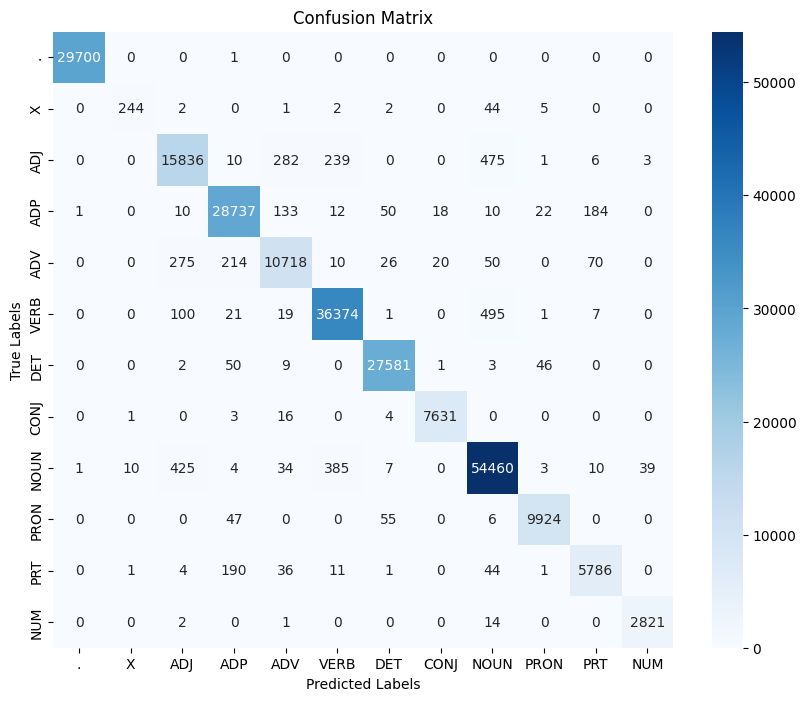

In [34]:

# Make predictions with the CRF model
y_pred = crf.predict(X_valid)

# Flatten the lists for metric calculations
y_valid_flat = [tag for sent in y_valid for tag in sent]
y_pred_flat = [tag for sent in y_pred for tag in sent]

# Sort labels
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))

# Print the classification report
print(classification_report(
    y_valid_flat, y_pred_flat, labels=sorted_labels, digits=3
))

# Compute the confusion matrix
cm = confusion_matrix(y_valid_flat, y_pred_flat, labels=sorted_labels)

# Convert confusion matrix to DataFrame for easier manipulation
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [35]:
# Identify maximal confusions
confusion_counts = cm_df.values
max_confusions = []

# Iterate through confusion matrix to find max confusions
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and confusion_counts[i][j] > 0:  # Exclude true positives
            max_confusions.append((labels[i], labels[j], confusion_counts[i][j]))

# Sort by confusion count
max_confusions.sort(key=lambda x: x[2], reverse=True)

# Display top confusions
print("Maximal Confusions (from label A to label B):")
for confusion in max_confusions[:5]:  # Show top 5 confusions
    print(f"Confusion: {confusion[0]} -> {confusion[1]}: {confusion[2]} times")

Maximal Confusions (from label A to label B):
Confusion: PRT -> ADJ: 495 times
Confusion: VERB -> ADJ: 475 times
Confusion: ADJ -> VERB: 425 times
Confusion: ADJ -> PRT: 385 times
Confusion: VERB -> ADP: 282 times


## Evaluating  the model on test data

In [36]:
# test data predictions

y_pred = crf.predict(X_test)

y_test_flat = [tag for sent in y_test for tag in sent]
y_pred_flat = [tag for sent in y_pred for tag in sent]

f1_score_weighted = f1_score(y_test_flat, y_pred_flat, average='weighted', labels=labels)
f0_5_score = fbeta_score(y_test_flat, y_pred_flat, average='weighted', beta=0.5, labels=labels)
f2_score = fbeta_score(y_test_flat, y_pred_flat, average='weighted', beta=2, labels=labels)

print("Weighted F1 Score: ", f1_score_weighted)
print("F0.5 Score: ", f0_5_score)
print("F2 Score: ", f2_score)

Weighted F1 Score:  0.981742766714618
F0.5 Score:  0.9817331690153202
F2 Score:  0.9817643115473499


              precision    recall  f1-score   support

           .      1.000     1.000     1.000     22263
           X      0.962     0.804     0.876       250
         ADJ      0.951     0.939     0.945     12619
         ADP      0.982     0.985     0.984     21962
         ADV      0.955     0.943     0.949      8498
        VERB      0.982     0.983     0.982     27811
         DET      0.995     0.996     0.996     20789
        CONJ      0.995     0.998     0.996      5729
        NOUN      0.979     0.984     0.981     41665
        PRON      0.992     0.989     0.991      7474
         PRT      0.956     0.953     0.954      4577
         NUM      0.984     0.994     0.989      2150

    accuracy                          0.982    175787
   macro avg      0.978     0.964     0.970    175787
weighted avg      0.982     0.982     0.982    175787



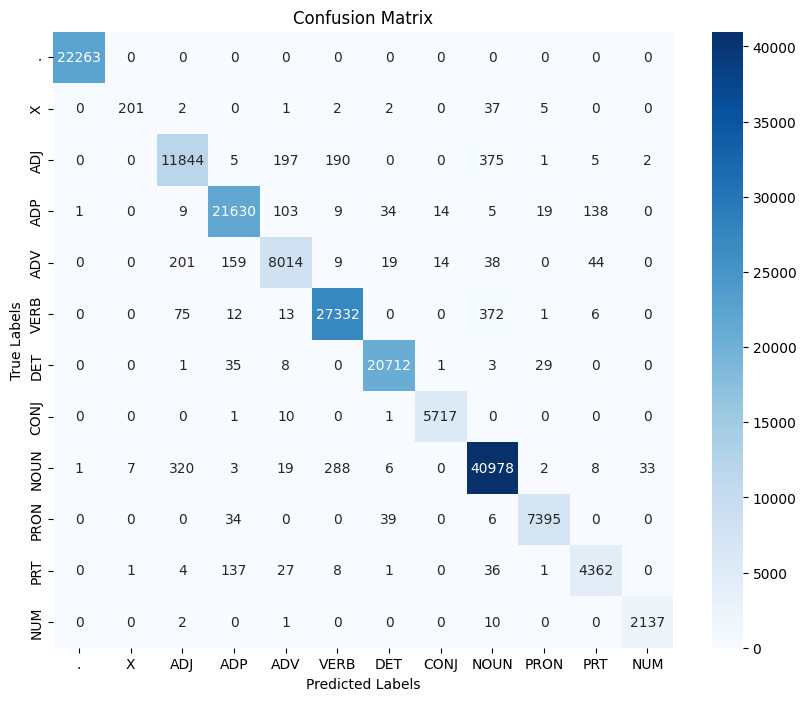

In [30]:


# Make predictions with the CRF model
y_pred = crf.predict(X_test)

# Flatten the lists for metric calculations
y_test_flat = [tag for sent in y_test for tag in sent]
y_pred_flat = [tag for sent in y_pred for tag in sent]

# Sort labels
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))

# Print the classification report
print(classification_report(
    y_test_flat, y_pred_flat, labels=sorted_labels, digits=3
))

# Compute the confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=sorted_labels)

# Convert confusion matrix to DataFrame for easier manipulation
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

We can see from above that test data accuracy is very close to validation set accuracy.

In [37]:
# Identify maximal confusions
confusion_counts = cm_df.values
max_confusions = []

# Iterate through confusion matrix to find max confusions
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and confusion_counts[i][j] > 0:  # Exclude true positives
            max_confusions.append((labels[i], labels[j], confusion_counts[i][j]))

# Sort by confusion count
max_confusions.sort(key=lambda x: x[2], reverse=True)

# Display top confusions
print("Maximal Confusions (from label A to label B):")
for confusion in max_confusions[:5]:  # Show top 5 confusions
    print(f"Confusion: {confusion[0]} -> {confusion[1]}: {confusion[2]} times")


Maximal Confusions (from label A to label B):
Confusion: PRT -> ADJ: 495 times
Confusion: VERB -> ADJ: 475 times
Confusion: ADJ -> VERB: 425 times
Confusion: ADJ -> PRT: 385 times
Confusion: VERB -> ADP: 282 times


In [49]:
# Prepare features for a single sentence
def prepare_single_sentence(sentence):
    return [word_features(sentence, i) for i in range(len(sentence))]

# Example input string
input_str = "The quick brown fox jumps over the lazy dog ."
sentence = [(word, '<POS>') for word in input_str.split(" ")]  # Dummy POS tags

# Prepare features for the CRF model
features = prepare_single_sentence(sentence)

# Predict with the CRF model
predicted_tags = crf.predict([features])[0]  # Pass features as a list of lists

# Output the results
print(f"Sentence: {' '.join(word for word, _ in sentence)}")
print(f"Predicted POS Tags: {predicted_tags}")

Sentence: The quick brown fox jumps over the lazy dog .
Predicted POS Tags: ['DET' 'ADJ' 'ADJ' 'NOUN' 'NOUN' 'ADP' 'DET' 'ADJ' 'NOUN' '.']


#### Gradio Interface for the GUI


In [48]:
import gradio as gr 

def predict_pos_tags(input_sentence):
    sentence = [(word, '<POS>') for word in input_sentence.split()]  # Dummy POS tags
    features = prepare_single_sentence(sentence)
    predicted_tags = crf.predict([features])[0]  # Predict with the CRF model
    
    # Create a DataFrame for better visualization
    result_df = pd.DataFrame({
        "Word": [word for word, _ in sentence],
        "Predicted POS Tag": predicted_tags
    })
    
    return result_df

# Gradio interface
iface = gr.Interface(
    fn=predict_pos_tags, 
    inputs=gr.Textbox(label="Input Sentence", placeholder="Enter a sentence here..."),  
    outputs=gr.DataFrame(label="Predicted POS Tags"),  
    title="CRF POS Tagger", 
    description="Enter a sentence to get the corresponding POS tags in a structured format." 
)

iface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


In [80]:
from collections import defaultdict

class HMM_POS_Tagger:
    def __init__(self, tagged_sentences):
        self.tagged_sentences = tagged_sentences
        self.tags = []
        self.words = []
        self.tag_counts = defaultdict(int)
        self.start_probs = defaultdict(float)
        self.word_tag_counts = defaultdict(int)
        self.transition_counts = defaultdict(int)
        self.emission_probs = defaultdict(lambda: defaultdict(float))
        self.transition_probs = defaultdict(lambda: defaultdict(float))

    def train(self, train_data):
    # Collect tags and words
        self.tags = [tag for sent in train_data for _, tag in sent]
        self.words = [word for sent in train_data for word, _ in sent]

    # Count occurrences of tags and (word, tag) pairs
        tag_bigrams = []
        for sentence in train_data:
            prev_tag = "<s>"  # Start of sentence tag
            for word, tag in sentence:
                self.tag_counts[tag] += 1
                self.word_tag_counts[(word, tag)] += 1
                tag_bigrams.append((prev_tag, tag))
                prev_tag = tag
            tag_bigrams.append((prev_tag, "</s>"))

        # Count transitions between tags
        for prev_tag, tag in tag_bigrams:
            self.transition_counts[(prev_tag, tag)] += 1

        # Calculate transition probabilities P(tag_i | tag_(i-1))
        for (prev_tag, tag), count in list(self.transition_counts.items()):  # Changed here
            self.transition_probs[prev_tag][tag] = count / sum(
                self.transition_counts[(prev_tag, _)] for _ in self.tag_counts
            )

        # Calculate emission probabilities P(word | tag)
        for (word, tag), count in self.word_tag_counts.items():
            self.emission_probs[tag][word] = count / self.tag_counts[tag]


    def viterbi(self, sentence):
        V = [{}]
        path = {}

        # Initialize base cases (t == 0)
        for tag in self.tag_counts:
            V[0][tag] = self.transition_probs["<s>"].get(tag, 0) * self.emission_probs[tag].get(sentence[0], 1e-10)
            path[tag] = [tag]

        # Run Viterbi for t > 0
        
        # Time Complexity O(L*T^2)
        # Space Complexity O(L*T)
        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for tag in self.tag_counts:
                (prob, state) = max(
                    [(V[t - 1][prev_tag] * self.transition_probs[prev_tag].get(tag, 0) *
                      self.emission_probs[tag].get(sentence[t], 1e-10), prev_tag) for prev_tag in self.tag_counts]
                )

                V[t][tag] = prob
                new_path[tag] = path[state] + [tag]

            path = new_path

        # Return the best path for the last word
        (prob, final_tag) = max((V[-1][tag], tag) for tag in self.tag_counts)
        return path[final_tag]

    def predict(self, sentence):
        return self.viterbi(sentence)
    
    def tag(self, words):
        return self.predict(words)

    def __getstate__(self):
        # Customize the state to be pickled
        state = self.__dict__.copy()
        # Remove any non-picklable attributes or replace them with picklable alternatives
        # For example, if using lambdas, replace with their intended behavior or remove
        state['transition_probs'] = dict(self.transition_probs)  # Convert defaultdict to dict
        state['emission_probs'] = dict(self.emission_probs)      # Convert defaultdict to dict
        state['start_probs'] = dict(self.start_probs)            # Convert defaultdict to dict
        state['tag_counts'] = dict(self.tag_counts)              # Convert defaultdict to dict
        state['transition_counts'] = dict(self.transition_counts)  # Convert defaultdict to dict
        state['word_tag_counts'] = dict(self.word_tag_counts)    # Convert defaultdict to dict
        return state
    
    def __setstate__(self, state):
        # Restore instance attributes
        self.__dict__.update(state)
        # Reconstruct any non-picklable attributes as needed
        self.transition_probs = defaultdict(lambda: defaultdict(float), state['transition_probs'])
        self.emission_probs = defaultdict(lambda: defaultdict(float), state['emission_probs'])
        self.start_probs = defaultdict(float, state['start_probs'])
        self.tag_counts = defaultdict(int, state['tag_counts'])
        self.transition_counts = defaultdict(int, state['transition_counts'])
        self.word_tag_counts = defaultdict(int, state['word_tag_counts'])

    def save(self, filename='hmm_model.pkl'):
        model_data = {
            'transition_probs': dict(self.transition_probs),
            'emission_probs': dict(self.emission_probs),
            'tag_counts': dict(self.tag_counts),
            'word_tag_counts': dict(self.word_tag_counts),
            'transition_counts': dict(self.transition_counts)
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f'HMM model saved to {filename}')

    @staticmethod
    def load(filename='hmm_model.pkl'):
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        hmm_tagger = HMM_POS_Tagger.__new__(HMM_POS_Tagger)
        hmm_tagger.transition_probs = model_data['transition_probs']
        hmm_tagger.emission_probs = model_data['emission_probs']
        hmm_tagger.tag_counts = model_data['tag_counts']
        hmm_tagger.word_tag_counts = model_data['word_tag_counts']
        hmm_tagger.transition_counts = model_data['transition_counts']
        return hmm_tagger
    


## Comparing the HMM POS Tagger with the CRF POS Tagger

In [81]:
# Load the HMM POS tagger model
loaded_hmm_tagger = HMM_POS_Tagger.load(filename='hmm_model.pkl')

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# Prepare data function
def prepare_data(sentences):
    X, y = [], []
    for sent in sentences:
        # Separate words and tags
        words = [word for word, tag in sent]
        tags = [tag for word, tag in sent]
        
        # Generate features using the word_features function
        # Pass the full sentence (sent) to word_features
        X.append([word_features(sent, i) for i in range(len(sent))])
        y.append(tags)
    return X, y


def evaluate_models(hmm_tagger, crf_model, test_sentences):
    test_x, test_y = prepare_data(test_sentences)
    test_words = [[word for word, _ in sent] for sent in test_sentences]

    # Predict using HMM
    y_pred_hmm = [hmm_tagger.predict(sent) for sent in test_words]

    # Predict using CRF
    y_pred_crf = crf_model.predict(test_x)

    # Flatten the lists for metric calculations
    y_true_flat = [tag for sent in test_y for tag in sent]
    y_pred_hmm_flat = [tag for sent in y_pred_hmm for tag in sent]
    y_pred_crf_flat = [tag for sent in y_pred_crf for tag in sent]

    # Calculate metrics for HMM
    hmm_acc = accuracy_score(y_true_flat, y_pred_hmm_flat)
    hmm_precision, hmm_recall, hmm_f1, _ = precision_recall_fscore_support(y_true_flat, y_pred_hmm_flat, average='weighted')

    # Calculate metrics for CRF
    crf_acc = accuracy_score(y_true_flat, y_pred_crf_flat)
    crf_precision, crf_recall, crf_f1, _ = precision_recall_fscore_support(y_true_flat, y_pred_crf_flat, average='weighted')

    # Print metrics
    print("HMM - Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1-Score: {:.3f}".format(hmm_acc, hmm_precision, hmm_recall, hmm_f1))
    print("CRF - Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1-Score: {:.3f}".format(crf_acc, crf_precision, crf_recall, crf_f1))

    # Confusion matrices
    cm_hmm = confusion_matrix(y_true_flat, y_pred_hmm_flat)
    cm_crf = confusion_matrix(y_true_flat, y_pred_crf_flat)

    # Plotting the confusion matrices
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_hmm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_labels, yticklabels=sorted_labels)
    plt.title('HMM Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_crf, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_labels, yticklabels=sorted_labels)
    plt.title('CRF Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.show()

    # Return metrics for comparison
    return {
        'hmm': {
            'accuracy': hmm_acc,
            'precision': hmm_precision,
            'recall': hmm_recall,
            'f1': hmm_f1,
            'confusion_matrix': cm_hmm,
            'predictions': y_pred_hmm_flat,
        },
        'crf': {
            'accuracy': crf_acc,
            'precision': crf_precision,
            'recall': crf_recall,
            'f1': crf_f1,
            'confusion_matrix': cm_crf,
            'predictions': y_pred_crf_flat,
        },
        'y_true': y_true_flat,
    }

HMM - Accuracy: 0.971, Precision: 0.971, Recall: 0.971, F1-Score: 0.971
CRF - Accuracy: 0.993, Precision: 0.993, Recall: 0.993, F1-Score: 0.993


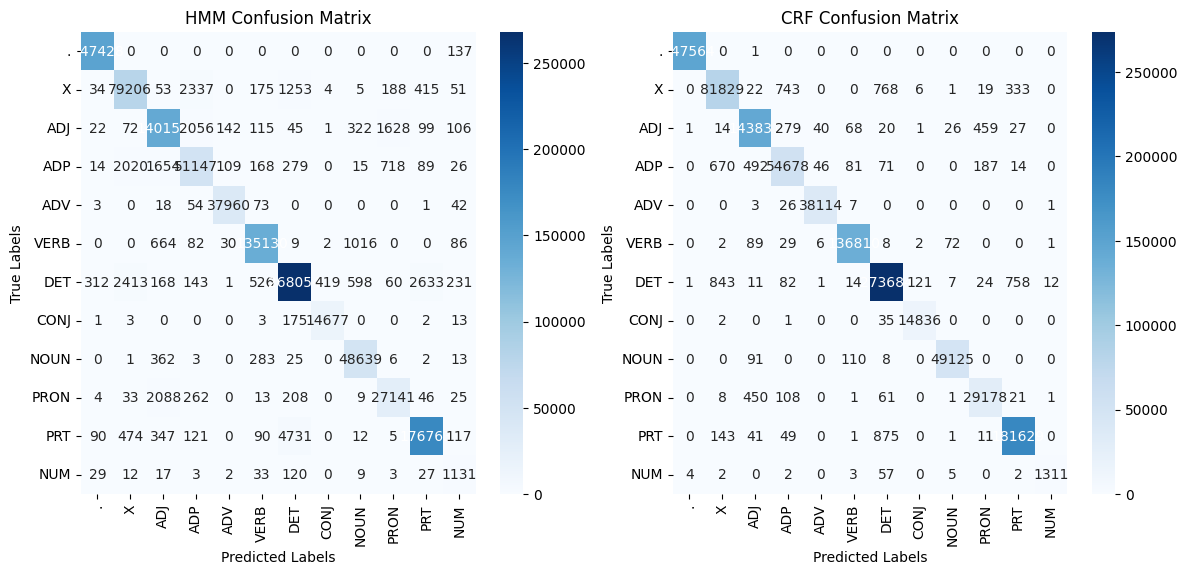

      Metric       HMM       CRF
0   Accuracy  0.970928  0.992591
1  Precision  0.971179  0.992586
2     Recall  0.970928  0.992591
3   F1-Score  0.971010  0.992587


In [78]:
from nltk.corpus import brown 


tagged_sentences = brown.tagged_sents(tagset='universal')

# Example usage
results = evaluate_models(loaded_hmm_tagger, crf, tagged_sentences)

# Summarize results in a table format
summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'HMM': [results['hmm']['accuracy'], results['hmm']['precision'], results['hmm']['recall'], results['hmm']['f1']],
    'CRF': [results['crf']['accuracy'], results['crf']['precision'], results['crf']['recall'], results['crf']['f1']],
})

print(summary_df)


In [85]:
import gradio as gr
import pandas as pd


def predict_pos_tags(input_sentence):
    sentence = [(word, '<POS>') for word in input_sentence.split()]  
    features = prepare_single_sentence(sentence)


    crf_predicted_tags = crf.predict([features])[0]
    hmm_predicted_tags = loaded_hmm_tagger.predict(input_sentence.split(' '))

    result_df = pd.DataFrame({
        "Word": [word for word, _ in sentence],
        "CRF Predicted POS Tag": crf_predicted_tags,
        "HMM Predicted POS Tag": hmm_predicted_tags
    })
    
    return result_df

iface = gr.Interface(
    fn=predict_pos_tags, 
    inputs=gr.Textbox(label="Input Sentence", placeholder="Enter a sentence here..."),  
    outputs=gr.DataFrame(label="Predicted POS Tags"),  
    title="CRF & HMM POS Tagger", 
    description="Enter a sentence to get the corresponding POS tags from both CRF and HMM models in a structured format." 
)

iface.launch()


Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\DIVYANSHU.LAPTOP-LRGNN2BQ\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DIVYANSHU.LAPTOP-LRGNN2BQ\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DIVYANSHU.LAPTOP-LRGNN2BQ\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1935, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DIVYANSHU.LAPTOP-LRGNN2BQ\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^